In [1]:
import sys
sys.path.append('/Users/lisa/Desktop/code_projects/dl_project/texture_vs_shape/scaling_mlps_mirror')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from scipy import stats
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import matplotlib.pyplot as plt
from models.networks import get_model, B_12_Wi_1024

/Users/lisa/Desktop/code_projects/dl_project/bachmann_venv39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model

In [3]:
#  sanity check with untrained model - blurry results 
# model=B_12_Wi_1024(dim_in=64 ** 2 * 3, dim_out=10, load_device='cpu', checkpoint=None)

In [54]:
# standard model 
#model = get_model(architecture='B_12-Wi_1024', resolution=64, num_classes=10,  checkpoint='in21k_cifar10', load_device='cpu',  dropout=0.0)

In [55]:
path='/Users/lisa/Desktop/code_projects/dl_project/texture_vs_shape/scaling_mlps_mirror/models/checkpoints/'

In [56]:
architecture='B_6-Wi_512'
checkpoint='wandb_vhd7bodg__epoch_1140__compute_611890379735040__B_6-Wi_512__imagenette-160__dropout_0 (1).3__rotations20__mixup__64'
all_first='all'

In [57]:
checkpoint_exp=torch.load(path+checkpoint,  map_location=torch.device('cpu'))

In [58]:
model = get_model(architecture=architecture, resolution=64, num_classes=10, load_device='cpu', checkpoint=None, dropout=0.0)

In [59]:
model.load_override_adjusted('/Users/lisa/Desktop/code_projects/dl_project/scaling_mlps_mirror/models/checkpoints/wandb_vhd7bodg__epoch_1140__compute_611890379735040__B_6-Wi_512__imagenette-160__dropout_0 (1).3__rotations20__mixup__64')

{'linear_in.weight': tensor([[ 0.0161,  0.0113,  0.0066,  ..., -0.0018,  0.0119,  0.0064],
        [ 0.0248,  0.0160,  0.0098,  ...,  0.0160,  0.0159,  0.0183],
        [-0.0030, -0.0129, -0.0104,  ..., -0.0097, -0.0088,  0.0056],
        ...,
        [-0.0108, -0.0122,  0.0019,  ...,  0.0047,  0.0001, -0.0187],
        [ 0.0114,  0.0114,  0.0127,  ..., -0.0009, -0.0090,  0.0160],
        [-0.0245, -0.0049, -0.0028,  ...,  0.0076, -0.0084, -0.0159]]), 'linear_in.bias': tensor([-1.0112e-01, -9.4638e-02, -1.5867e-01, -6.0868e-02, -1.2493e-01,
        -1.5223e-01,  2.0407e-01,  1.9724e-01, -9.3992e-02,  2.7805e-01,
        -1.1703e-01, -6.3783e-02,  1.8957e-01, -6.1886e-02,  1.4815e-01,
        -1.3579e-02, -1.2986e-01,  2.4182e-01, -2.4186e-01, -2.5411e-01,
         5.7957e-02,  1.6440e-01,  1.6728e-01, -1.6783e-01,  1.7375e-01,
         4.1772e-02,  9.6374e-04,  2.6339e-01, -1.9327e-01,  1.1582e-01,
         1.2635e-01, -7.3040e-02, -8.1976e-02,  1.4346e-01, -6.8273e-02,
        -8.4276

### Build dataloader

In [60]:
class RandomNoiseDataset(Dataset):
    def __init__(self, num_images, image_size):
        self.num_images = num_images
        self.image_size = image_size

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        # Create a random noise image
        image = np.random.rand(self.image_size[0], self.image_size[1], 3)
        # Convert the numpy array to a PyTorch tensor
        image = torch.from_numpy(image).float()
        # Permute the tensor to have the channel as the first dimension
        image = image.permute(2, 0, 1)
        # Set requires_grad to True
        image.requires_grad_(True)
        return image


In [61]:
# Create the dataset
dataset = RandomNoiseDataset(num_images=1000, image_size= (64, 64))

# Create the data loader
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)


In [62]:
# Function to visualize an image from the data loader
def visualize_random_noise_image(data_loader):
    # Get a batch of images
    images = next(iter(data_loader))
    # Take the first image from the batch
    image = images[0]
 # Detach the image from the computation graph and convert to numpy for visualization
    image = image.detach().cpu().numpy()
    print(image.shape)
    # Permute the numpy array to have the channel as the last dimension
    image = np.transpose(image, (1, 2, 0))
    print(image.shape)
    # Plot the image
    plt.imshow(image)
    plt.axis('off') # Turn off axis
    plt.show()

(3, 64, 64)
(64, 64, 3)


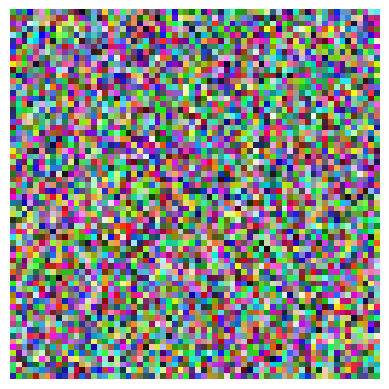

In [63]:
visualize_random_noise_image(data_loader)

### Computing Gradients 

In [64]:
gradients_across_batches = []
for images in data_loader:

    # create a new tensor with the same data but reshape to ensure it is a leaf
    input = torch.tensor(images.clone().view(images.size(0), -1), requires_grad=True)
    input_gradients = torch.zeros_like(input[0])

    for i in range(10):
        if all_first=='first':
            # first linear layer only 
            predictions = model.linear_in(input)
        if all_first=='all':

            # all layers 
            predictions = model(input)
        loss = torch.sum(predictions[:,i]) # return x before out in forward pass for 1024

        loss.backward()

        input_gradients += torch.mean(input.grad, axis=0)**2

        input.grad.zero_()

    
    gradients_across_batches = [input_gradients] #.append(mean_gradients)


    break



/var/folders/bj/l1ndbbhd1gq9wlgybtnxvr5r0000gn/T/ipykernel_20112/2504401979.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(images.clone().view(images.size(0), -1), requires_grad=True)


In [65]:
stacked_gradients = torch.stack(gradients_across_batches, dim=0) 
mean_gradient = torch.mean(stacked_gradients, dim=0)

In [66]:
mean_gradient=np.array(mean_gradient).reshape(3, 64, 64)

In [67]:
channel1=mean_gradient[0, :, :]
channel2=mean_gradient[1, :, :]
channel3=mean_gradient[2, :, :]

### Visualize results

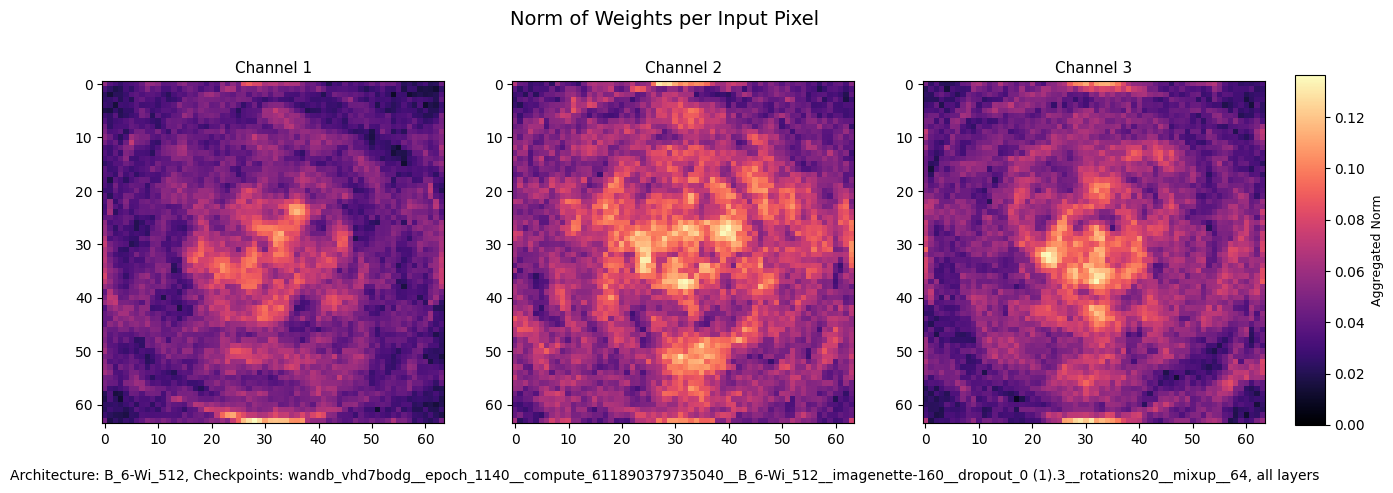

In [71]:

import textwrap
import os

# Assuming 'channel1', 'channel2', and 'channel3' are your data
channel1_sqrt = np.sqrt(channel1)
channel2_sqrt = np.sqrt(channel2)
channel3_sqrt = np.sqrt(channel3)

# Create a 1x3 grid of subplots with a common title
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot channel 1
im1 = axs[0].imshow(channel1_sqrt, cmap='magma', vmin=0)
axs[0].set_title('Channel 1', size=11)

# Plot channel 2
im2 = axs[1].imshow(channel2_sqrt, cmap='magma', vmin=0)
axs[1].set_title('Channel 2', size=11)

# Plot channel 3
im3 = axs[2].imshow(channel3_sqrt, cmap='magma', vmin=0)
axs[2].set_title('Channel 3', size=11)

# Add a colorbar to the last subplot
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [x, y, width, height]
cbar = fig.colorbar(im3, cax=cbar_ax)
cbar.set_label('Aggregated Norm', fontsize=9)

# Adjust tick label font sizes for all subplots
for ax in axs:
    ax.tick_params(axis='both', labelsize=10)

# Common title
title = 'Norm of Weights per Input Pixel'

# Description text
description=f'Architecture: {architecture}, Checkpoints: {checkpoint}, {all_first} layers'


# Wrap the description text to multiple lines with a specified line width
description_lines = textwrap.wrap(description, width=180)

# Combine the description lines into a single string with line breaks
description_text = '\n'.join(description_lines)

# Add the common title
fig.suptitle(title, fontsize=14)

# Add the wrapped description text below the common title
fig.text(0.5, 0.04, description_text, ha='center', fontsize=10)

# Specify the folder path where you want to save the plot
output_folder = '/Users/lisa/Desktop/code_projects/dl_project/texture_vs_shape/scaling_mlps_mirror/student_project/weight_exploration/visualizations'

# Ensure the output folder exists or create it if not
os.makedirs(output_folder, exist_ok=True)

# Save the plot to the specified folder
output_filepath = os.path.join(output_folder, f'norm_weights_{architecture}_{checkpoint}_{all_first}.jpg')
plt.savefig(output_filepath)
# Show the plot
plt.show()
